In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

In [3]:
mnist_train = dset.MNIST(root="../", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root="../", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [4]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train),len(mnist_test))

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


In [5]:
#drop_last는 배치로 묶고 남은데이터를 어떻게 할건지임. true면 버림
train_loader = DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 1 28 28 -> 16 24 24
        # 16 24 24 -> 32 20 20
        # 32 20 20 -> 32 10 10
        # 32 10 10 -> 64 6 6
        # 64 6 6 -> 64 3 3
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),             
            nn.ReLU(),                                                          
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),           
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                          
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),          
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                              
        )
        
        # batch size, 64*3*3  -> batch size 100
        # batch size, 100  -> batch size 10
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*3*3,100),                                             
            nn.ReLU(),
            nn.Linear(100,10)                                                   
        )
        
    def forward(self,x):
        out = self.layer(x)                                                   
        out = out.view(batch_size,-1)                                                                                                                                                                            
        out = self.fc_layer(out)
        return out

In [7]:
# gpu 설정이 가능하면 gpu설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [8]:
#train
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3079, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1965, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1188, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1487, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0700, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0691, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0685, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0469, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0215, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0355, device='cuda:0', grad_fn=<NllLossBackward>)


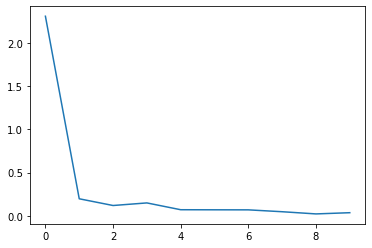

In [9]:
#epoch당 loss보기
plt.plot(loss_arr)
plt.show()

In [10]:
#test
correct = 0
total = 0

with torch.no_grad():
    for image,label in test_loader:
        x = image.to(device)
        y_= label.to(device)
        output = model.forward(x)
    
        _,output_index = torch.max(output,1)
        
        # drop_last의 영향으로 데이터가 잘릴수도 있으므로 total을 직접 구해줌.
        total += label.size(0)
        
        correct += (output_index == y_).sum().float()
    
    #정확도 print
    print("Accuracy of Test Data: {}%".format(100*correct/total))


Accuracy of Test Data: 98.7880630493164%
